In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# Seed para que las redes con iguales parametros no generen resultados aleatorios y tener repetibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas importamos matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Función para plotear
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

#Función Rounded Accuracy
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full_normalized = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full_normalized[:-5000], X_train_full_normalized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#Función para ver los resultados de las reconstrucciones
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
#definimos la operacion kernel como un kernel gaussiano

def rbf_kernel(X, Y, sigma=1.0):
    X_expanded = tf.expand_dims(X, axis=1)  # Shape: (batch_size, 1, latent_dim)
    Y_expanded = tf.expand_dims(Y, axis=0)  # Shape: (1, batch_size, latent_dim)
    squared_distance = tf.reduce_sum(tf.square(X_expanded - Y_expanded), axis=2)
    return tf.exp(-squared_distance / (2 * sigma ** 2))

#definimos la operacion MMD
def compute_mmd(z, z_prior, kernel_fn):

    # Calcula los kernels
    K_zz = kernel_fn(z, z)
    K_zz_prior = kernel_fn(z, z_prior)
    K_prior_prior = kernel_fn(z_prior, z_prior)

    # Calcula MMD
    mmd = tf.reduce_mean(K_zz) + tf.reduce_mean(K_prior_prior) - 2 * tf.reduce_mean(K_zz_prior)
    return mmd


In [4]:
#Definimos una funcion para crear el encoder con la API funcional
def build_encoder(latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = keras.layers.RandomFlip(mode="horizontal")(encoder_inputs)#Usamos unas capas de random flip y random contrast para aumentar artificialmente los datos de entrada
    x = keras.layers.RandomContrast(factor=0.2)(x)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

#Definimos la función que crea el decoder con la API funcional
def build_decoder(latent_dim):
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7*7*64, activation='relu')(decoder_inputs)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder

#Esta clase se crea para introducir las propiedades del autoencode variacional, en particular el loss probabilistico
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, alpha=0.01,sigma=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha #Este parametro se usara para darle peso a la regularizacion con el loss KL
        self.sigma = sigma  # Kernel bandwidth
        
#La funcion call de la clase VAE calcula el loss por MMD usando los datos de salida del encoder, y luego los añade
#usado el metrodo add_loss
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        z_prior = tf.random.normal(shape=tf.shape(z))
        mmd_loss = self.alpha * compute_mmd(z, z_prior, lambda x, y: rbf_kernel(x, y, sigma=self.sigma))
        self.add_loss(mmd_loss)
        return reconstructed
    
#Esta funcion se usa en la función call para convertir las muestras del espacio latente en un conjunto continuo y diferenciable, y asi 
#el espacio latente se convierte en la nube de probabilidad
    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean

#Para poder usar el parametro de escalado y darle pesos a los diferentes loss creamos una clase para un loss custom escalado
class ScaledBinaryCrossentropy:
    #la funcion init para inicializar el factor de escalada
    def __init__(self, scale=1.0):
        self.scale = scale
        
    #En la funcion call se calcula la perdida escalada y la retorna
    def __call__(self, y_true, y_pred):
        # Calcula la binary crossentropy
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Retorna la binary crossentropy escalada
        return self.scale * bce

In [6]:
#Luego de definir las funcions y la clase VAE, se crea y compila  el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 8
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Definimos los pesos que llevaran los loss
alpha = 0.6
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 0.1 
#Usamos la clase VAE para definir el modelo
vae = VAE(encoder, decoder,alpha,sigma)

#Creamos el objeto loss que va a calcular la crossentropia escalada
loss2=ScaledBinaryCrossentropy(beta)
#Compilamos
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [7]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))

Epoch 1/100


I0000 00:00:1727391406.899414     106 service.cc:145] XLA service 0x7a200400aeb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727391406.899472     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727391406.899476     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  36/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2899 - rounded_accuracy: 0.6646 

I0000 00:00:1727391415.019961     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.2199 - rounded_accuracy: 0.7950 - val_loss: 0.1681 - val_rounded_accuracy: 0.8965
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1611 - rounded_accuracy: 0.9087 - val_loss: 0.1653 - val_rounded_accuracy: 0.9016
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1581 - rounded_accuracy: 0.9149 - val_loss: 0.1624 - val_rounded_accuracy: 0.9080
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1566 - rounded_accuracy: 0.9180 - val_loss: 0.1601 - val_rounded_accuracy: 0.9126
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1556 - rounded_accuracy: 0.9201 - val_loss: 0.1588 - val_rounded_accuracy: 0.9150
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1549 - rounded_accuracy: 0.9215 - val_loss: 0.1567 - val_rounded_accuracy: 0.9197
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1543 - rounded_accuracy: 0.9227 - val_loss: 0.1563 - val_rounde

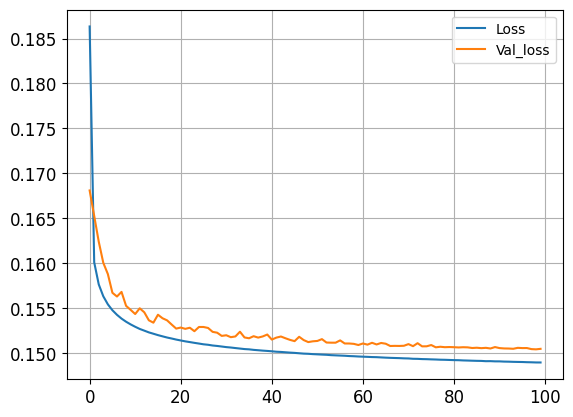

In [8]:
#Graficamos el loss de entrenamiento y validación
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.49,0.52)
plt.legend()
plt.show()

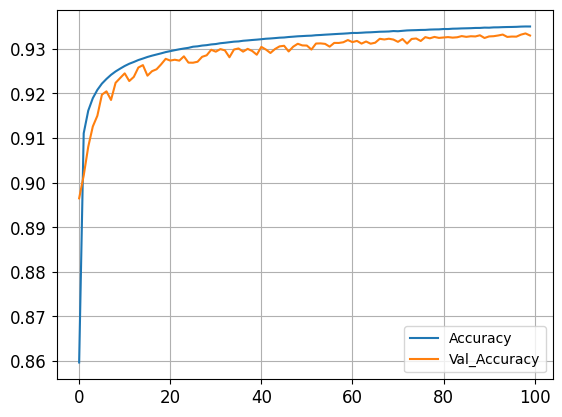

In [9]:
#Graficamos el accuracy de entrenamiento y el de validación

plt.plot(history.history["rounded_accuracy"],label="Accuracy")
plt.plot(history.history["val_rounded_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.7,0.75)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


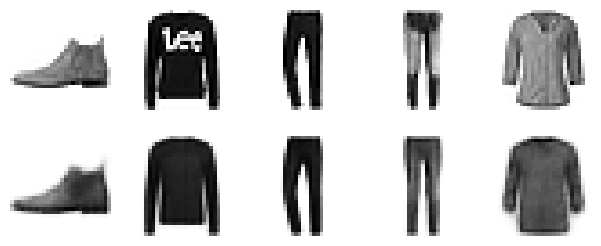

In [10]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae)
plt.show()

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


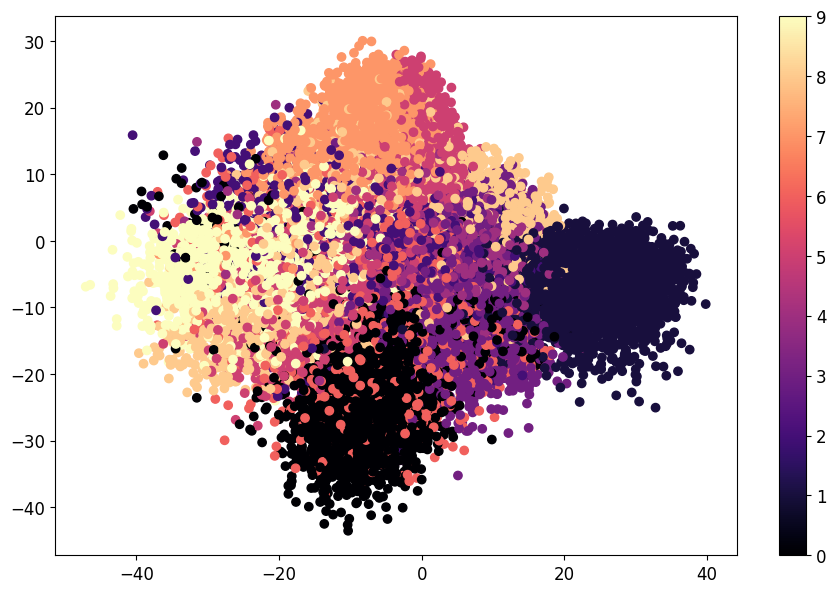

In [11]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


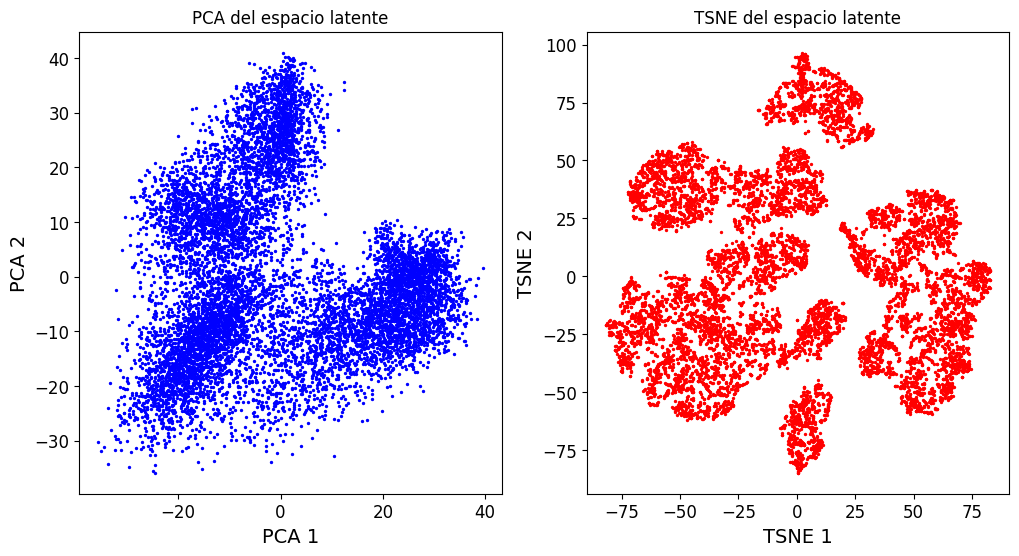

In [12]:
#Para revisar el espacio latente usamos PCA y TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extraer los valores latentes
z_mean, _ = vae.encoder.predict(X_test)

# Aplicar PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)

# Aplicar TSNE
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z_mean)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# PCA
plt.subplot(1, 2, 1)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c='blue', s=2)
plt.title('PCA del espacio latente')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# TSNE
plt.subplot(1, 2, 2)
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c='red', s=2)
plt.title('TSNE del espacio latente')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')

plt.show()

**Por comparación vamos a revisar que pasa cuando no se añade el MMD, y cuando el ancho de banda es muy pequeño y muy grande**

In [13]:
#Luego de definir las funcions y la clase VAE, se crea y compila  el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 8
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Definimos los pesos que llevaran los loss
alpha = 0
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 0.1 
#Usamos la clase VAE para definir el modelo
vae_0 = VAE(encoder, decoder,alpha,sigma)


#Creamos el objeto loss que va a calcular la crossentropia escalada
loss2=ScaledBinaryCrossentropy(beta)
#Compilamos
vae_0.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [14]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae_0.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.4093 - rounded_accuracy: 0.8306 - val_loss: 0.3274 - val_rounded_accuracy: 0.8941
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3039 - rounded_accuracy: 0.9125 - val_loss: 0.3161 - val_rounded_accuracy: 0.9031
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2970 - rounded_accuracy: 0.9185 - val_loss: 0.3047 - val_rounded_accuracy: 0.9123
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2936 - rounded_accuracy: 0.9213 - val_loss: 0.2998 - val_rounded_accuracy: 0.9162
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2914 - rounded_accuracy: 0.9231 - val_loss: 0.2986 - val_rounded_accuracy: 0.9172
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2900 - rounded_accuracy: 0.9244 - val_loss: 0.2952 - val_rounded_accuracy: 0.9203
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2887 - rounded_accuracy: 0.9255 - val_loss: 0.2970 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


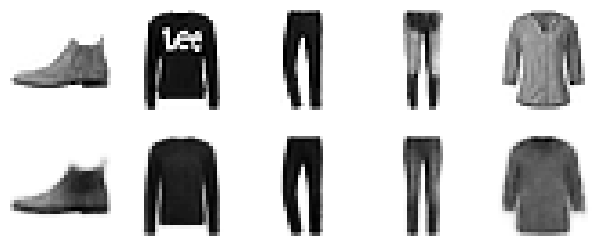

In [15]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae_0)
plt.show()

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


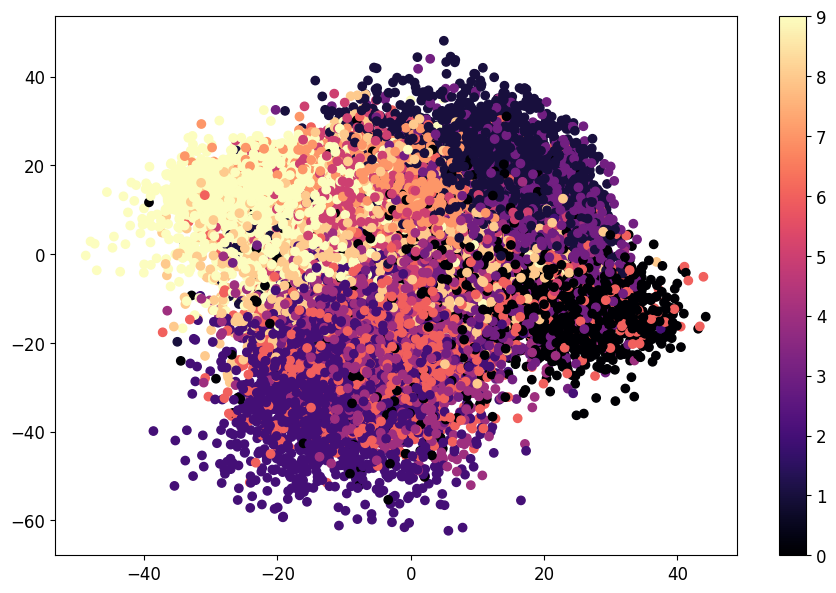

In [16]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae_0.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

**Verificamos que pasa si el sigma es muy pequeño**

In [17]:
#Luego de definir las funcions y la clase VAE, se crea y compila  el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 8
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Definimos los pesos que llevaran los loss
alpha = 0.6
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 0.0001 
#Usamos la clase VAE para definir el modelo
vae_min = VAE(encoder, decoder,alpha,sigma)

#Creamos el objeto loss que va a calcular la crossentropia escalada
loss2=ScaledBinaryCrossentropy(beta)
#Compilamos
vae_min.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [18]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae_min.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.2170 - rounded_accuracy: 0.8020 - val_loss: 0.1667 - val_rounded_accuracy: 0.8988
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1611 - rounded_accuracy: 0.9083 - val_loss: 0.1629 - val_rounded_accuracy: 0.9065
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1581 - rounded_accuracy: 0.9147 - val_loss: 0.1600 - val_rounded_accuracy: 0.9122
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1566 - rounded_accuracy: 0.9177 - val_loss: 0.1585 - val_rounded_accuracy: 0.9153
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1556 - rounded_accuracy: 0.9198 - val_loss: 0.1574 - val_rounded_accuracy: 0.9175
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1549 - rounded_accuracy: 0.9212 - val_loss: 0.1570 - val_rounded_accuracy: 0.9185
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1544 - rounded_accuracy: 0.9225 - val_loss: 0.1563 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


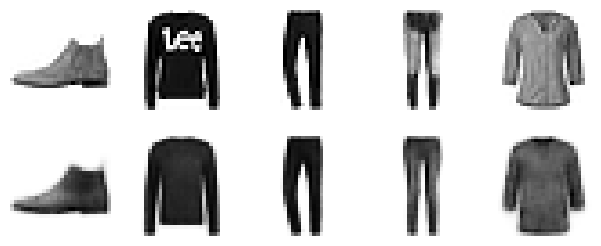

In [19]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae_min)
plt.show()

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


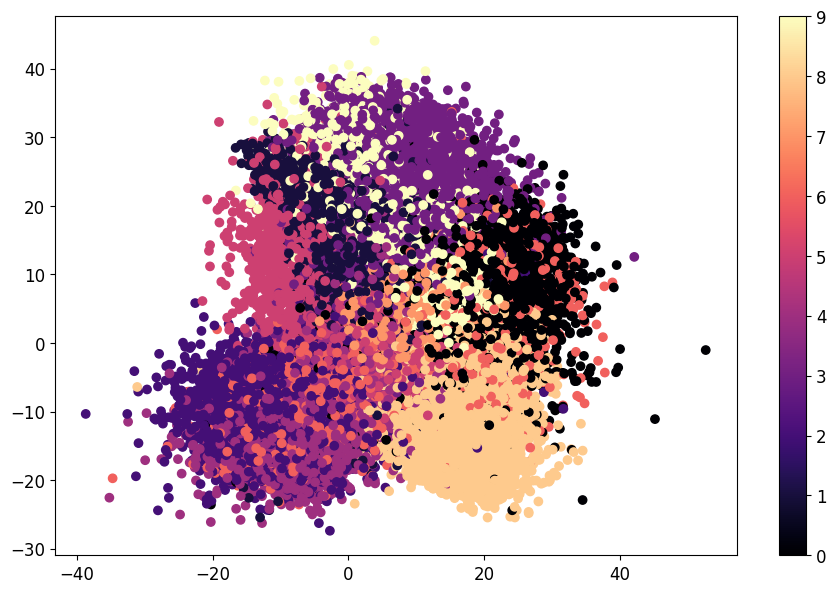

In [20]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae_min.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

**Ahora con un sigma muy grande**

In [21]:
#Luego de definir las funcions y la clase VAE, se crea y compila  el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 8
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Definimos los pesos que llevaran los loss
alpha = 0.6
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 10000
#Usamos la clase VAE para definir el modelo
vae_max = VAE(encoder, decoder,alpha,sigma)

#Creamos el objeto loss que va a calcular la crossentropia escalada
loss2=ScaledBinaryCrossentropy(beta)
#Compilamos
vae_max.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [22]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae_max.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.1763 - rounded_accuracy: 0.8089 - val_loss: 0.1294 - val_rounded_accuracy: 0.8985
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1239 - rounded_accuracy: 0.9085 - val_loss: 0.1278 - val_rounded_accuracy: 0.9018
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1210 - rounded_accuracy: 0.9146 - val_loss: 0.1242 - val_rounded_accuracy: 0.9097
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1194 - rounded_accuracy: 0.9178 - val_loss: 0.1239 - val_rounded_accuracy: 0.9095
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1184 - rounded_accuracy: 0.9198 - val_loss: 0.1206 - val_rounded_accuracy: 0.9171
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1176 - rounded_accuracy: 0.9214 - val_loss: 0.1202 - val_rounded_accuracy: 0.9175
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1170 - rounded_accuracy: 0.9224 - val_loss: 0.1194 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


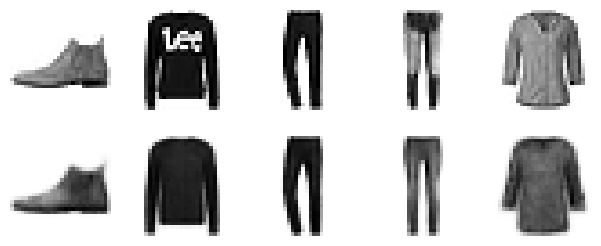

In [23]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae_max)
plt.show()

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


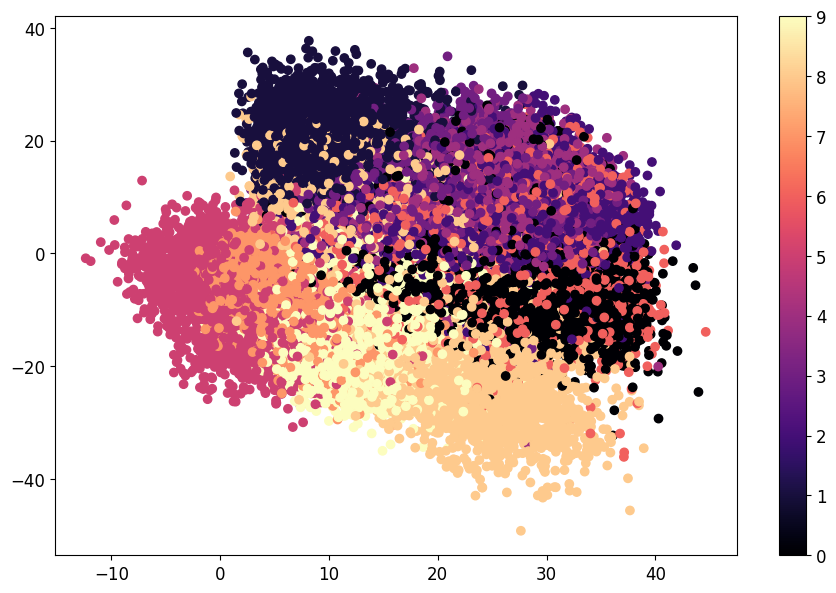

In [24]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae_max.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

# Discusion

**Se puede ver que la MMD cumple bien el papel de regularizar el espacio latente como lo hacia la divergencia KL, el loss empeoró en general al eliminar esta regularizacion de la red.**

**El parametro sigma no tiene tanto impacto en la reconstrucción pero si en la regularización, el espacio latente aparenta ser mucho más disperso al poner valores muy extremos de sigma, tanto pequeños como grandes.**